In [28]:
#Credit Scoring Model by Arif
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn")
sns.set_palette("husl")



In [29]:
#Load data
def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

    # drop ID column
    train.drop(train.columns[0], axis=1, inplace=True)
    test.drop(test.columns[0], axis=1, inplace=True)

    print("Train shape:", train.shape)
    print("Test  shape:", test.shape)

    return train, test

In [30]:
#Feature engineering
def feature_engineering(df):
    df = df.copy()

    # Fix invalid delinquency values
    bad_cols = [
        'NumberOfTime30-59DaysPastDueNotWorse',
        'NumberOfTime60-89DaysPastDueNotWorse',
        'NumberOfTimes90DaysLate'
    ]

    for col in bad_cols:
        df[col] = df[col].replace([96, 98], np.nan)

    # Cap utilization (extreme outliers)
    df['RevolvingUtilizationOfUnsecuredLines'] = \
        df['RevolvingUtilizationOfUnsecuredLines'].clip(upper=10)

    # Age cannot be zero
    df['age'] = df['age'].replace(0, np.nan)

    # Engineered features
    df['HasDependents'] = (df['NumberOfDependents'] > 0).astype(int)
    df['HighDebtRatio'] = (df['DebtRatio'] > 1).astype(int)

    df['IncomePerDependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)

    df['TotalPastDue'] = (
        df['NumberOfTime30-59DaysPastDueNotWorse'] +
        df['NumberOfTime60-89DaysPastDueNotWorse'] +
        df['NumberOfTimes90DaysLate']
    )

    df['HasPastDue'] = (df['TotalPastDue'] > 0).astype(int)

    df['CreditLinesPerRealEstate'] = \
        df['NumberOfOpenCreditLinesAndLoans'] / (df['NumberRealEstateLoansOrLines'] + 1)

    # Imputation
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
    df['IncomePerDependent'] = df['IncomePerDependent'].fillna(df['IncomePerDependent'].median())
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)

    df = df.fillna(df.median(numeric_only=True))

    return df

In [31]:
#Split data
def create_splits(df):
    X = df.drop("SeriousDlqin2yrs", axis=1)
    y = df["SeriousDlqin2yrs"]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\nTrain shape:", X_train.shape)
    print("Valid shape:", X_val.shape)

    return X_train, X_val, y_train, y_val, X

In [32]:
#Random forest model
def train_random_forest(X_train, y_train, X_val, y_val):
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_leaf=40,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)
    preds = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)

    print("\nRandomForest Validation AUC:", auc)

    return rf, auc

In [33]:
#Logistic regression
def train_logistic_regression(X_train, y_train, X_val, y_val):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(X_train_s, y_train)

    preds = lr.predict_proba(X_val_s)[:, 1]
    auc = roc_auc_score(y_val, preds)

    print("Logistic Regression AUC:", auc)
    return lr, auc, scaler

In [34]:
#Feature importance plot
def plot_feature_importance(model, X):
    feat_imp = pd.DataFrame({
        "feature": X.columns,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=feat_imp.head(12), x="importance", y="feature")
    plt.title("Top 12 Feature Importances")
    plt.show()

In [35]:
#Make submission
def save_submission(model, test_df, filename="submission.csv"):
    preds = model.predict_proba(test_df)[:, 1]
    sub = pd.DataFrame({
        "Id": np.arange(1, len(preds) + 1),
        "Probability": preds
    })
    sub.to_csv(filename, index=False)
    print(f"\nSaved → {filename}")

Train shape: (150000, 11)
Test  shape: (101503, 11)

Train shape: (120000, 16)
Valid shape: (30000, 16)

RandomForest Validation AUC: 0.8674084301658784
Logistic Regression AUC: 0.8590816582405392
Missing columns in test: set()
Extra columns in test: {'SeriousDlqin2yrs'}

RANDOM FOREST METRICS
Precision: 0.2351008916001877
Recall   : 0.7496259351620947
F1-score : 0.357942367230293

LOGISTIC REGRESSION METRICS
Precision: 0.22286908493805047
Recall   : 0.7446384039900249
F1-score : 0.3430606617647059


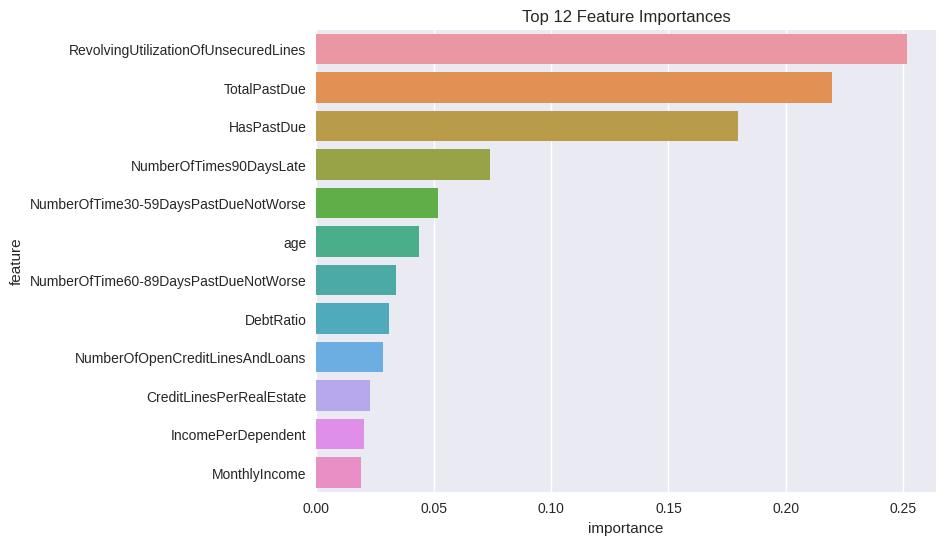


Saved → submission.csv

FINAL RESULTS
Random Forest AUC : 0.8674084301658784
Logistic Reg AUC  : 0.8590816582405392


In [36]:
# Main execution
TRAIN_PATH = '/kaggle/input/GiveMeSomeCredit/cs-training.csv'
TEST_PATH  = '/kaggle/input/GiveMeSomeCredit/cs-test.csv'

# Load data
train_raw, test_raw = load_data(TRAIN_PATH, TEST_PATH)

# Feature engineering
train = feature_engineering(train_raw)
test  = feature_engineering(test_raw)   # Safe: test has no target column

# Split train data
X_train, X_val, y_train, y_val, X_all = create_splits(train)

# Train models
rf_model, auc_rf = train_random_forest(X_train, y_train, X_val, y_val)
lr_model, auc_lr, scaler = train_logistic_regression(X_train, y_train, X_val, y_val)

# Check column alignment
missing_cols = set(X_all.columns) - set(test.columns)
extra_cols   = set(test.columns) - set(X_all.columns)

print("Missing columns in test:", missing_cols)
print("Extra columns in test:", extra_cols)

# Fix missing columns
for col in missing_cols:
    test[col] = 0

# Arrange final test set
X_test_final = test[X_all.columns]


#METRICS: Precision/Recall/F1

from sklearn.metrics import precision_score, recall_score, f1_score

# Predict on validation set
rf_probs = rf_model.predict_proba(X_val)[:, 1]
lr_probs = lr_model.predict_proba(scaler.transform(X_val))[:, 1]

# Binarize using default threshold 0.5
rf_preds = (rf_probs >= 0.5).astype(int)
lr_preds = (lr_probs >= 0.5).astype(int)

# Random Forest metrics
precision_rf = precision_score(y_val, rf_preds)
recall_rf    = recall_score(y_val, rf_preds)
f1_rf        = f1_score(y_val, rf_preds)

# Logistic Regression metrics
precision_lr = precision_score(y_val, lr_preds)
recall_lr    = recall_score(y_val, lr_preds)
f1_lr        = f1_score(y_val, lr_preds)

print("\nRANDOM FOREST METRICS")
print("Precision:", precision_rf)
print("Recall   :", recall_rf)
print("F1-score :", f1_rf)

print("\nLOGISTIC REGRESSION METRICS")
print("Precision:", precision_lr)
print("Recall   :", recall_lr)
print("F1-score :", f1_lr)

# Plot feature importance
plot_feature_importance(rf_model, X_all)

# Make submission
save_submission(rf_model, X_test_final)

# Final AUC results
print("\nFINAL RESULTS")
print("Random Forest AUC :", auc_rf)
print("Logistic Reg AUC  :", auc_lr)
